## <center>Solve the DDEs </center>

\begin{cases}
y'(t)= ay(t-\tau),&\\
y(t)=1 for all t<0&
\end{cases}

## <center>with Newton </center>

(Take a= \pi / 2)

In [3]:
from math import factorial
import numpy as np

## Right-hand-side of the simple DDE
def simple(a):
    def simple_dde(t, y1, y2):
        return -a*y2
    return simple_dde


## Constant one history function
def phi_0(t):
    return 1


def simple_exact(a, t_0, t_f, tau, N): 
    if t_0 != 0:
        raise ValueError("t_0 should be set to 0")
    t = np.linspace(t_0, t_f, N+1)
    y = np.zeros(len(t))
    for i, ti in enumerate(t):
        n = int(np.floor(ti / tau)) + 1 
        y[i] = 1
        for k in range(1, n+1):
            y[i] += (-a)**k * (ti - (k-1)*tau)**k / factorial(k)
    return y

In [1]:
import numpy as np

#Interpolation con Newton (hacia atrás)

def y_delayed_newton_backward(t, y, t_q, number_pts=3):
    #order  : grado deseado (usa hasta order+1 puntos hacia atrás)


    j = np.searchsorted(t, t_q) - 1     # Aquí busco el último índice con t[i] <= t_q
    max_pts = j + 1  # Número máximo de puntos disponibles por la izquierda
    pts = min(number_pts, max_pts) #Numero de puntos que vamos a usarrrr

    idx = np.arange(j - pts + 1, j + 1)  # vector (j-pts+1,j-pts+2,...,j,j+1), para calcular (y(j-pts+1),y(j-pts+2),...,y(j,+j+1))
    t_sub = t[idx]   #tiempos disponibles
    y_sub = y[idx]   #Valores disponibles


    coef = np.array(y_sub, dtype=float) # = [yj−pts+1​,yj−pts+2​,…,yj​]


    # Diferencias divididas backward, lo que vamos a hacer es recalcular coef:
    #  osea primero yj,  
    #  luego yj-y(j-1)/(tj - tj-1), 
    #  luego (y(j)-y(j-1))/(tj - tj-1) - (y(j-1)-y(j-2))/(tj-1 - tj-2) / (tj - tj-2) ...


    #En la primera pasada (NO BACKWARDS)(POR EJEMPLO) coef = [y3, y4, y5, y6]
    #En la segunda: coef = [y3, Δy4, Δy5, Δy6]
    #En la tercera: coef = [y3, Δy4, Δ²y5, Δ²y6]
    #En la cuarta y última: coef = [y3, Δy4, Δ²y5, Δ³y6]

    #Otro ejemplo sí backwards:
    #coef = [a, b, c, d] = [y[j-3], y[j-2], y[j-1], y[j]]
    #coef = [ y[j], Δᵇ y[j], Δᵇ² y[j], Δᵇ³ y[j] ]


    #Recordar que necesitamos las diferencias divididas para calcular el polinomio de Newton Backwards: 
    #        P(x)=f(tj) + f[tj,tj-1](x-tj) + f[tj,tj-1,tj-2](x-tj)(x-tj-1) + ...
    for k in range(1, pts):
        for i in range(pts - 1 , k - 1, -1):  #pts-1 pq acuerdate de que tenemos j+1 puntos en coef[i]
            #                                   y que coef[0] es f[tj], coef[1] es f[tj,tj-1], ...      
            coef[i] = (coef[i] - coef[i-1]) / (t_sub[i] - t_sub[i-k])  #calculamos f[ti,ti-1] para k=1, 
            #                                                               o f[ti,ti-1,ti-2] para k=2, ...

    # Evaluación (Newton backward-Horner)
    p = coef[pts-1]
    for k in range(pts-2, -1, -1):
        p = coef[k] + (t_q - t_sub[k]) * p    #Simplemente va evaluando el pol de Newton progresivamente
        # Si no se entiende pues a papel y lo entiendes


    return p




from scipy.optimize import fsolve

## Implicit Euler
def IE_newton_dde(f, phi, t_0, t_f, tau, N, history=False,pts=5):

    ## Preliminaries
    h = (t_f - t_0) / N
    t = np.linspace(t_0, t_f, N+1)
    y = np.zeros(len(t))
    y[0] = phi(t_0)
    
    ## IE with linear interpolation for delay term
    for i in range(0, N):
        if t[i] < tau:
            y_impl = lambda x : -x + y[i] + h*f(t[i+1], x, phi(t[i+1] - tau))
            y[i+1] = fsolve(y_impl, [y[i]])[0]
        else:
            y_impl = lambda x : -x + y[i] + h*f(t[i+1], x, y_delayed_newton_backward(t, y, t[i+1] - tau,pts))
            y[i+1] = fsolve(y_impl, [y[i]])[0]

    if history == True: ## Wether the solution should include the history (values on the interval [t_0 - tau, t_0])
        t_hist = np.linspace(t_0-tau, t_0, int(N / (t_f // tau) + 1))
        y_hist = np.array([phi(ti) for ti in t_hist])
        t = np.concatenate((t_hist, t))
        y = np.concatenate((y_hist, y))

    return h, t, y

C:\Users\natal\AppData\Local\Temp\ipykernel_27920\625556627.py:72: RuntimeWarning: The iteration is not making good progress, as measured by the 
 improvement from the last ten iterations.
  y[i+1] = fsolve(y_impl, [y[i]])[0]


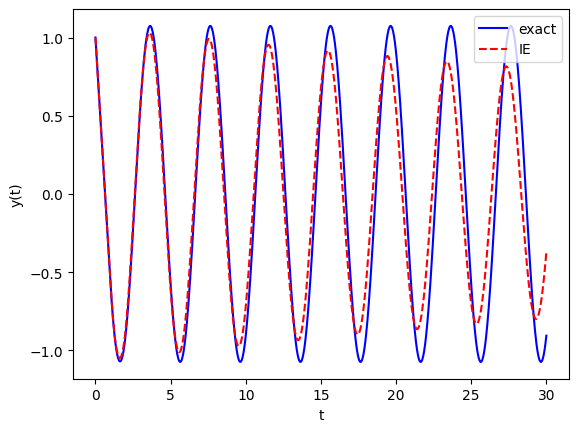

In [4]:
import matplotlib.pyplot as plt

a = np.pi / 2
t_0 = 0
t_f = 30
tau = 1
N = 10**3

h, t, y = IE_newton_dde(simple(a), phi_0, t_0, t_f, tau, N, False,pts=2) 
exact = simple_exact(a, t_0, t_f, tau, N)

plt.plot(t, exact, color='blue', label='exact')
plt.plot(t, y, 'r--', label='IE')
plt.xlabel('t')
plt.ylabel('y(t)')
plt.legend()
#plt.plot(t, np.zeros(len(t)), color='black')

A MEDIDA QUE AUMENTO LOS PUNTOS PEOR

NO SE QUE PASA EN PTS=10